In [1]:
import sys
import os
sys.path.append(os.path.abspath('..')) 
from utils.utils import get_text

: 

In [ ]:
get_text('/home/miza/Magisterka/src/data/images/13.jpg')

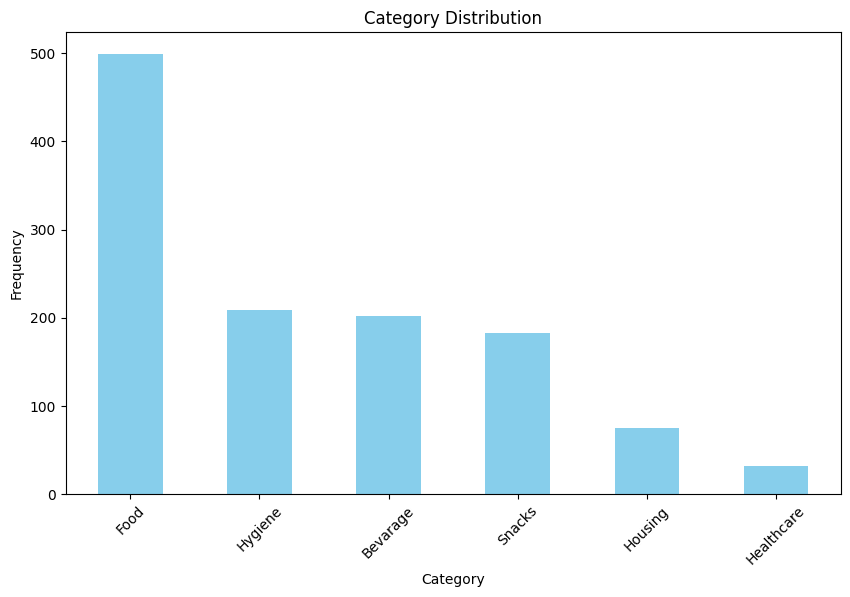

In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
df = pd.read_csv('/home/miza/Magisterka/src/data/gpt_generated_data.csv')



label_encoder = LabelEncoder()
df['Category_encoded'] = label_encoder.fit_transform(df['Category'])

df.head()

import matplotlib.pyplot as plt

# Assuming df is already loaded from your CSV
# Create the histogram for the 'Category' column
plt.figure(figsize=(10, 6))
df['Category'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Category Distribution')
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()


In [32]:
import torch
from torch import nn
from transformers import BertTokenizer, BertModel

class BertMultiHead(nn.Module):
    def __init__(self, bert_model_name, num_categories):
        super(BertMultiHead, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.dropout = nn.Dropout(0.3)
        
        # Head for category prediction (classification)
        self.category_classifier = nn.Linear(self.bert.config.hidden_size, num_categories)
        
        # Head for cost prediction (regression)
        self.cost_regressor = nn.Linear(self.bert.config.hidden_size, 1)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)

        category_logits = self.category_classifier(pooled_output)
        cost_prediction = self.cost_regressor(pooled_output)

        return category_logits, cost_prediction.squeeze()


/home/miza/.cache/pypoetry/virtualenvs/magisterka-eeyuwOSn-py3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

def encode_text(text_list, tokenizer, max_length=64):
    return tokenizer(text_list, padding='max_length', truncation=True, max_length=max_length, return_tensors='pt')

inputs = encode_text(df['OCR_product'].tolist(), tokenizer)
labels_category = torch.tensor(df['Category_encoded'].values)
labels_cost = torch.tensor(df['Correct_cost'].values, dtype=torch.float32)


In [ ]:
from torch.utils.data import TensorDataset, DataLoader

dataset = TensorDataset(inputs['input_ids'], inputs['attention_mask'], labels_category, labels_cost)
loader = DataLoader(dataset, batch_size=8, shuffle=True)

model = BertMultiHead('bert-base-multilingual-cased', num_categories=df['Category_encoded'].nunique())
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
criterion_category = nn.CrossEntropyLoss()
criterion_cost = nn.MSELoss()

model.train()
epochs = 3

for epoch in range(epochs):
    for batch in loader:
        input_ids, attention_mask, labels_cat, labels_cost = batch

        optimizer.zero_grad()
        logits_cat, pred_cost = model(input_ids, attention_mask)

        loss_cat = criterion_category(logits_cat, labels_cat)
        loss_cost = criterion_cost(pred_cost, labels_cost)

        loss = loss_cat + loss_cost  # Combined loss (can use weighting if needed)
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")


In [ ]:
model.eval()
sample_text = "Ryż bialu 1kg 0 x4.29 34.32"
encoded_input = encode_text([sample_text], tokenizer)

with torch.no_grad():
    logits_cat, pred_cost = model(encoded_input['input_ids'], encoded_input['attention_mask'])
    predicted_category_id = torch.argmax(logits_cat, dim=1).item()
    predicted_category = label_encoder.inverse_transform([predicted_category_id])[0]
    predicted_cost = pred_cost.item()

print(f"Predicted Category: {predicted_category}, Predicted Cost: {predicted_cost:.2f}")
